# XGBoost

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phuongkhanh21","key":"0fd6eb70e1509aad441adeb76f0dfff2"}'}

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d berkanoztas/synthetic-transaction-monitoring-dataset-aml

import zipfile

with zipfile.ZipFile("synthetic-transaction-monitoring-dataset-aml.zip", 'r') as zip_ref:
    zip_ref.extractall("synthetic_transaction_data")

import pandas as pd
os.listdir("synthetic_transaction_data")
df = pd.read_csv("synthetic_transaction_data/SAML-D.csv")
df.head(5)

Dataset URL: https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml
License(s): CC-BY-NC-SA-4.0
 61% 117M/193M [00:00<00:00, 1.22GB/s]
100% 193M/193M [00:00<00:00, 760MB/s] 


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

In [5]:
def custom_split(df, validation_dt=70, test_dt=35):
  # validation_cut_off=70: selects transactions for validation set, from the final 70 days prior to the dataset's latest date
  # test_cut_off=40: selects transactions for test set, from the final 70 days prior to the dataset's latest date

  test_cutoff = df['Date'].max() - pd.Timedelta(days=test_dt)
  validation_cutoff = df['Date'].max() - pd.Timedelta(days=validation_dt)

  test_set = df[df.Date >= test_cutoff]
  validation_set = df[(df.Date >= validation_cutoff) & (df.Date < test_cutoff)]
  train_set = df[df.Date < validation_cutoff]

  return train_set, validation_set, test_set

In [6]:
def recast(df):
  exclude = ['Sender_account', 'Receiver_account']
  for col in df.select_dtypes(include=['int64', 'int32']).columns:
    if col not in exclude:
      if df[col].max() < 127:
        df[col] = df[col].astype('int8')
      elif df[col].max() < 32767:
        df[col] = df[col].astype('int16')
      elif df[col].max() < 2147483647:
        df[col] = df[col].astype('int32')
      else:
        df[col] = df[col].astype('int64')
  return df

In [7]:
df = recast(df)

In [8]:
df_train, df_val, df_test = custom_split(df.copy())

In [9]:
def temporal_features(df):

  df['year'] = df['Date'].dt.year
  df['month'] = df['Date'].dt.month
  df['day_of_month'] = df['Date'].dt.day
  df['day_of_week'] = df['Date'].dt.dayofweek
  df['day_of_year'] = df['Date'].dt.dayofyear
  df['hour'] = df['Time'].dt.hour
  df['minute'] = df['Time'].dt.minute
  df['second'] = df['Time'].dt.second

  return df

In [10]:
def feature_engineer(df):

  # dropping column Laundering_type
  df = df.drop(columns = ["Laundering_type"])

  # fanin_30d: Number of unique sender accounts that sent money to a given receiver in the past 30 days.
  df['fanin_30d'] = df.groupby(['Receiver_account', pd.Grouper(key='Date', freq='30D')])['Sender_account'].transform('nunique')

  # fan_in_out_ratio: For each account, the number of unique inbound counterparties divided by the number of unique outbound counterparties in a 30-day window.
  df['fanout_30d'] = df.groupby(['Sender_account', pd.Grouper(key='Date', freq='30D')])['Receiver_account'].transform('nunique')
  df['fan_in_out_ratio'] = df['fanin_30d']/df['fanout_30d']
  df['fan_in_out_ratio'] = df['fan_in_out_ratio'].fillna(0)

  # fanin_intensity_ratio: Measures concentration—how many unique senders per daily inbound transaction.
  df['daily_receive'] = df.groupby(['Receiver_account', pd.Grouper(key='Date', freq='1D')])['Sender_account'].transform('nunique')
  df['fanin_intensity_ratio'] = df['fanin_30d']/df['daily_receive']
  df['fanin_intensity_ratio'] = df['fanin_intensity_ratio'].fillna(0)

  # amount_dispersion_std: Volatility of transaction amounts sent by each sender.
  df['amount_dispersion_std'] = df.groupby(['Sender_account'])['Amount'].transform('std')
  df['amount_dispersion_std'] = df['amount_dispersion_std'].fillna(0)

  # sent_to_received_ratio_monthly: For each account, total received amount divided by total sent amount over a monthly window.
  df['monthly_receive'] = df.groupby(['Receiver_account', pd.Grouper(key='Date', freq='ME')])['Amount'].transform('sum')
  df['monthly_send'] = df.groupby(['Sender_account', pd.Grouper(key='Date', freq='ME')])['Amount'].transform('sum')
  df['sent_to_received_ratio_monthly'] = df['monthly_receive']/df['monthly_send']
  df['sent_to_received_ratio_monthly'] = df['sent_to_received_ratio_monthly'].fillna(0)

  # back_and_forth_transfers: Number of unique transfers from a sender account to a receiver account in a single calendar day.
  df['back_and_forth_transfers'] = df.groupby(['Sender_account', 'Receiver_account', pd.Grouper(key='Date', freq='1D')])['Amount'].transform('count')

  # daily_receiver_transaction/weekly_receiver_transaction: Number of unique transaction from a receiver account in a single/week calendar day.
  df['daily_receiver_transaction'] = df.groupby(['Receiver_account', pd.Grouper(key='Date', freq='1D')])['Amount'].transform('count')
  df['weekly_receiver_transaction'] = df.groupby(['Receiver_account', pd.Grouper(key='Date', freq='1W')])['Amount'].transform('count')

  # daily_sender_transaction/weekly_sender_transaction: Number of unique transaction from a sender account in a single/week calendar day.
  df['daily_sender_transaction'] = df.groupby(['Sender_account', pd.Grouper(key='Date', freq='1D')])['Amount'].transform('count')
  df['weekly_sender_transaction'] = df.groupby(['Sender_account', pd.Grouper(key='Date', freq='1W')])['Amount'].transform('count')

  return df

In [12]:
import networkx as nx
import collections

In [13]:
def computing_circular_transaction(df):

  # circular_transaction_count: count of unique simple directed cycles that include an account (or a specific transaction edge) within 30 days.

  grouped = df.groupby(pd.Grouper(key='Date', freq='30D'))

  results = []

  for window_start, group in grouped:   # each 'group' is a DataFrame
      G = nx.DiGraph()
      # Now you can safely iterate rows of this group
      for _, row in group.iterrows():
          G.add_edge(row['Sender_account'], row['Receiver_account'])

      cycles = list(nx.simple_cycles(G))

      circular_count = collections.defaultdict(int)
      for cycle in cycles:
          for node in cycle:
              circular_count[node] += 1

      for node, count in circular_count.items():
          results.append({
              "Date": window_start,
              "Sender_account": node,
              "circular_transaction_count": count
          })

  cycle_features = pd.DataFrame(results)

  df = df.merge(
    cycle_features,
    on=['Date', 'Sender_account'],
    how='left'
    )

  df['circular_transaction_count'] = df['circular_transaction_count'].fillna(0)

  return df

In [14]:
# Training whole dataset
df_combined_train = pd.concat([df_train, df_val])
df_combined_train.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [15]:
df_combined_train = temporal_features(df_combined_train)
df_combined_train = feature_engineer(df_combined_train)
df_combined_train = computing_circular_transaction(df_combined_train)
df_combined_train = recast(df_combined_train)

In [16]:
df_test = temporal_features(df_test)
df_test = feature_engineer(df_test)
df_test = computing_circular_transaction(df_test)
df_test = recast(df_test)

In [17]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

In [18]:
opt_features = ['year', 'month', 'day_of_month', 'day_of_week', 'day_of_year', 'hour', 'minute', 'second',
            'fanin_30d', 'fan_in_out_ratio', 'fanin_intensity_ratio', 'amount_dispersion_std',
            'sent_to_received_ratio_monthly', 'back_and_forth_transfers',
            'circular_transaction_count', 'Is_laundering']

In [19]:
best_params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.5,
    'n_estimators': 500,
    'objective': 'binary:logistic',   # or 'multi:softprob' for multiclass
    'eval_metric': 'logloss',
    'random_state': 42
}


In [21]:
# Retrain on full training data
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(df_combined_train[opt_features[:-1]], df_combined_train[opt_features[-1]])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [24]:
# Evaluate on test set
from sklearn.metrics import confusion_matrix
y_pred = final_model.predict(df_test[opt_features[:-1]])

In [25]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
cm = confusion_matrix(df_test.Is_laundering, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1029162      28]
 [    573     625]]


In [31]:
report_dict = classification_report(df_test.Is_laundering, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict)
report_df

,0,1,accuracy,macro avg,weighted avg
precision,9.994435e-01,0.957121,0.999417,9.782823e-01,9.993943e-01
recall,9.999728e-01,0.521703,0.999417,7.608378e-01,9.994167e-01
f1-score,9.997081e-01,0.675311,0.999417,8.375094e-01,9.993309e-01
support,1.029190e+06,1198.000000,0.999417,1.030388e+06,1.030388e+06


In [32]:
import shap

In [34]:
explainer = shap.TreeExplainer(final_model)

In [36]:
shap_values = explainer.shap_values(df_test[opt_features[:-1]])
expected_value = explainer.expected_value

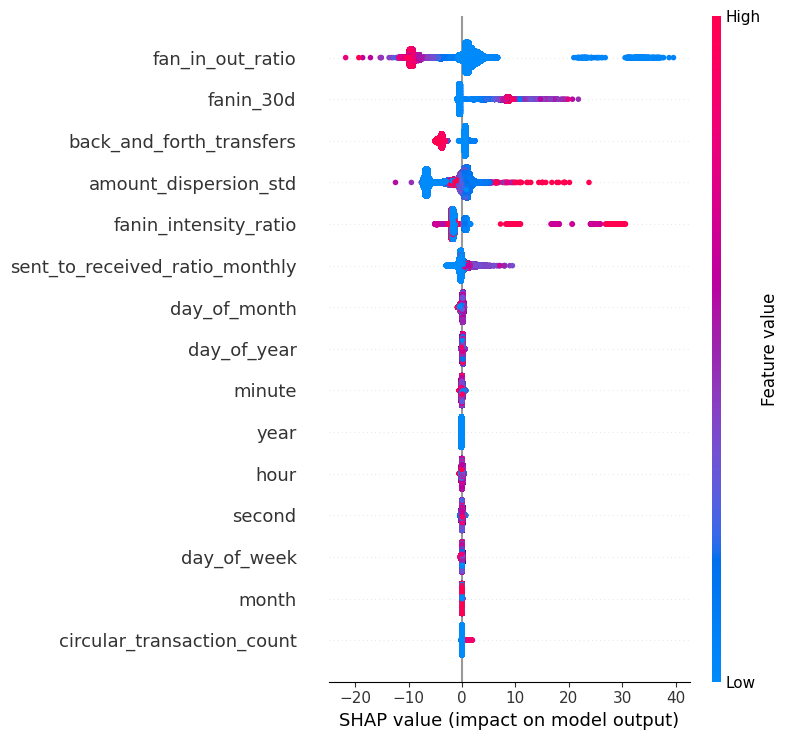

In [37]:
shap.summary_plot(shap_values, df_test[opt_features[:-1]], feature_names=opt_features[:-1])